In [1]:
# https://keras.io/
!pip install -q keras
import keras

Using TensorFlow backend.


In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, DepthwiseConv2D
from keras.layers import Concatenate
from keras.models import load_model
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger
from sklearn.model_selection import train_test_split

In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [0]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 100
l = 6
num_filter = 35
compression = 1.0
dropout_rate = 0.20

In [5]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

def preprocess_data(data_set):
    mean = np.array([125.3, 123.0, 113.9])
    std = np.array([63.0, 62.1, 66.7])

    data_set -= mean
    data_set /= std
    return data_set

x_train = preprocess_data(x_train)
x_test = preprocess_data(x_test)

# Divide dataset into train/val/test sets 45000/5000/10000
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.10)

170500096/170498071 [==============================] - 24s 0us/step


In [0]:
# Data augementation
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.125,
    height_shift_range=0.125,
    horizontal_flip=True,
    fill_mode='nearest',
    zoom_range=0.10
)

datagen_train.fit(x_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


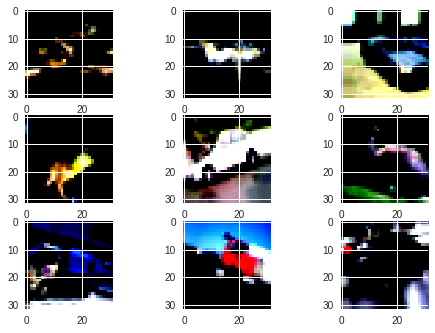

In [7]:
# Visualize data augementation
for X_batch, y_batch in datagen_train.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i], cmap=plt.get_cmap('gray'))
    plt.show()
    break

In [0]:
# Dense Block
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [0]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [0]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

In [0]:
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [0]:
model = Model(inputs=[input], outputs=[output])
model.summary()

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),#SGD(lr=0.1, momentum=0.9, decay=0.0001, nesterov=True),
              metrics=['accuracy'])

In [0]:
def decay_fn(epoch, lr):
    if epoch < 50:
        return 0.001
    elif epoch >= 50 and epoch < 75:
        return 0.0001
    else:
        return 0.00001

lr_scheduler = LearningRateScheduler(decay_fn)

csv_logger = CSVLogger('training.log')

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, min_lr = 0.000001)

early_stop = EarlyStopping(monitor = "val_loss", patience = 10)

filepath = "{epoch:03d}-{val_acc:.3f}.hdf5"
model_chkpt = ModelCheckpoint(filepath, monitor = "val_loss", save_best_only=True, verbose = 1)

In [0]:
%%time

'''
Setting the verbosity to 1 causes "Buffered data was truncated after reaching the output size limit."
error after 15-20 epochs, the training continues in the background but no further details are shown.
Simple fix for it is setting verbose equal to 2 or 0(no output).
'''

history = model.fit_generator(
    datagen_train.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=(len(x_train)/batch_size)*5,
    epochs=epochs,
    verbose = 2,
    validation_data=(x_val, y_val),
    callbacks = [lr_scheduler, csv_logger, model_chkpt],
    #initial_epoch=50
)

In [0]:
# Full training logs can be seen using this.
train_log = pd.read_csv("training.log")
train_log.head(100)

In [0]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_log['acc'])
plt.plot(train_log['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(train_log['loss'])
plt.plot(train_log['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [0]:
# Save the trained weights in to .h5 format
model.save("DNST_model.h5")
print("Saved model to disk")

In [0]:
# Load the model with best accuracy to evaluate
# model = load_model("017-0.903.hdf5")

# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
from google.colab import files

files.download('DNST_model.h5')